## 1. Business Understanding

Flight delays have become a major problem for air traffic systems around the world. The aviation industry is constantly suffering from the economic losses associated with flight delays. According to the United States
Bureau of Transportation Statistics (BTS), in 2018, more than 20% of U.S. flights were delayed. These delays have a serious economic impact in the United States, amounting to $40.7 billion per year. Passengers suffer lost time, missed business opportunities or leisure activities, and airlines that attempt to compensate for delays
cause additional fuel consumption and a greater negative impact on the environment. impact on the environment. To reduce the negative economic and environmental impacts of unexpected flight delays, and to meet the increasing
demand for air travel with increasing flight delays. accurate forecasting of flight delays at airports is needed.

## 2. Data and Data Understanding

The first problem is already the data set. The problem here is that Excel can display a maximum of 1,048,576 rows and 16,384 columns. The data set data set has seven times more rows than Excel can display. Therefore, only a text editor, database application like MS Access


## 2.1. Import of Relevant Modules¶


In [3]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

## 2. 2. Read Data flights.csv 

In [4]:
df = pd.read_csv('https://storage.googleapis.com/ml-service-repository-datastorage/flight_delay_prediction_data_flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

# Gibt einige Informationen zu Spaltentypen und Anzahl der Nullwerte
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (3555162, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,11725,1,1,1,66278,66278,68264,68264,7,78848,78848,1,70565,70565,1,70565,78848,1,1,3486323,2846100,2846100,2846100,2846100,2846100
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.329802,0.000028,0.000028,0.000028,1.864275,1.864275,1.920138,1.920138,0.000197,2.217845,2.217845,0.000028,1.98486,1.98486,0.000028,1.98486,2.217845,0.000028,0.000028,98.063689,80.055424,80.055424,80.055424,80.055424,80.055424


In [5]:
df.shape

(3555162, 31)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3555162 entries, 0 to 3555161
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  float64
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             float64
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    float64
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             float64
 24

## 2.2.1 Read Data airports.csv 

# 2. Step - Transfer of the data frame into a dictionary for later classification.

In [7]:
airports = pd.read_csv('https://storage.googleapis.com/ml-service-repository-datastorage/flight_delay_prediction_data_airports.csv')

## 2.3 Data Cleansing

In [8]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [9]:
# function that converts the string 'HHMM' to datetime.time

def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

    # function that converts the string 'HHMM' to datetime.time
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

    # Function that combines two columns of the data frame to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [10]:
# Modification of the variables within the data frame
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


In [11]:
# Remove unneeded columns from the dataframe
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


In [12]:
# Check for completeness using missing_df
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['Variablen', 'Fehlende Werte']
missing_df['Füllungsfaktor (%)']=(df.shape[0]-missing_df['Fehlende Werte'])/df.shape[0]*100
missing_df.sort_values('Füllungsfaktor (%)').reset_index(drop = True)

,Variablen,Fehlende Werte,Füllungsfaktor (%)
0,ARRIVAL_DELAY,78848,97.782155
1,ELAPSED_TIME,78848,97.782155
2,ARRIVAL_TIME,70565,98.015140
3,DEPARTURE_TIME,66278,98.135725
4,DEPARTURE_DELAY,66278,98.135725
5,SCHEDULED_TIME,7,99.999803
6,ORIGIN_AIRPORT,1,99.999972
7,DESTINATION_AIRPORT,1,99.999972
8,SCHEDULED_DEPARTURE,1,99.999972
9,SCHEDULED_ARRIVAL,1,99.999972


## Comparison between all airlines according to delays

# 2.4 Step Reading the CSV "Airlines

In [13]:
airlines_names = pd.read_csv('https://storage.googleapis.com/ml-service-repository-datastorage/flight_delay_prediction_data_airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [14]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

## 2.4. Descriptive Analytics¶

In [15]:
# Function that extracts statistical parameters from a group object:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

# Creation of a data framework with statistical information on each airline:global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-24.0,644.0,35808.0,9.315516
HA,-26.0,1433.0,46564.0,0.263272
F9,-32.0,1112.0,52691.0,16.314323
NK,-37.0,836.0,67460.0,18.810495
AS,-47.0,963.0,103397.0,1.905481
B6,-27.0,942.0,158179.0,11.834643
MQ,-36.0,1154.0,181314.0,12.325976
US,-35.0,759.0,194825.0,6.141137
UA,-40.0,1314.0,304834.0,16.437320


## 2.4.1 Creation of the graphic for the dataframe

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


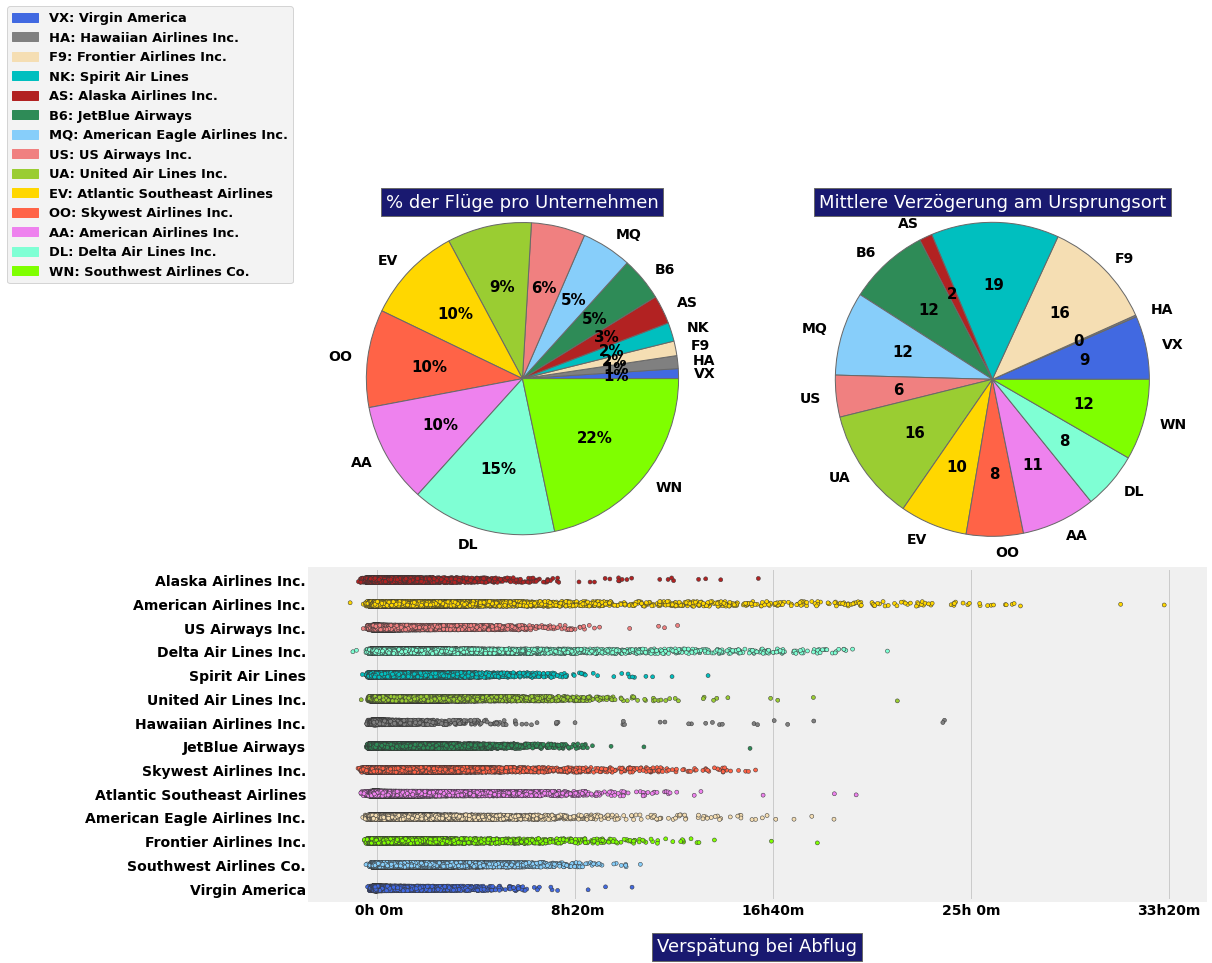

In [16]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches

# Extrahiere der Untermenge von Spalten und definiere die Beschriftung der Fluggesellschaften neu 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)

colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']

fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 

# Erstellung des 1. Piecharts
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% der Flüge pro Unternehmen', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)

# Erstellung einer Legende mit den Airline-namen
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)

# Kreisdiagramm Nr. 2 mit der Mittlere Verspätung bei Abflug

sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mittlere Verzögerung am Ursprungsort', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)

# Erstellung eines Striplot mit allen Werten, die für die Verzögerungen gemeldet wurden

colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Verspätung bei Abflug', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

## 2.4.2 Creation of a bar chart for the representation of flights in relation to delays

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


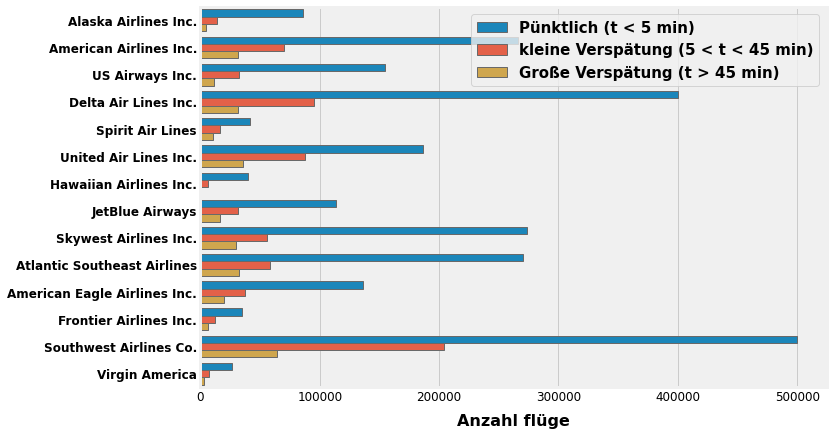

In [17]:
# Funktion, die definiert, wie Verzögerungen gruppiert werden
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
# ersetzen der Abkürzungen durch die vollständigen Namen der Firmen
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0)
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0)
ax.yaxis.label.set_visible(False)
plt.xlabel('Anzahl flüge', fontsize=16, weight = 'bold', labelpad=10)
# Legende
L = plt.legend()
L.get_texts()[0].set_text('Pünktlich (t < 5 min)')
L.get_texts()[1].set_text('kleine Verspätung (5 < t < 45 min)')
L.get_texts()[2].set_text('Große Verspätung (t > 45 min)')
plt.show()

## Distribution of delays: creation of a ranking list of airlines

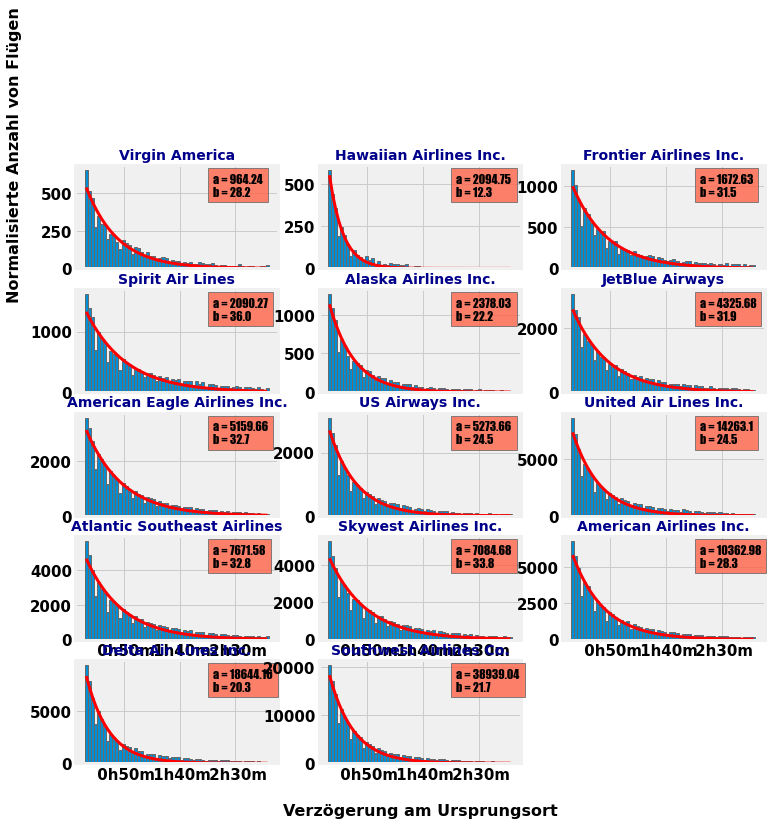

In [18]:
# Modellfunktion, die zur Anpassung der Histogramme verwendet wird

def func(x, a, b):
    return a * np.exp(-x/b)
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    # Anpassung der Verteilung
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    # Erfassung der Ergebnisse
    points.append(popt)
    label_company.append(carrier_name)
    # Zeichnen der Anpassungskurve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    # Beschriftungen für jedes Teilplot definieren
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
# Nebenplot-Titel
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    # Achsenbeschriftungen 
    if i == 4:
        ax.text(-0.3,0.9,'Normalisierte Anzahl von Flügen', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Verzögerung am Ursprungsort', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    # Legende: Werte der a- und b-Koeffizienten
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()

##  prediction of flight delays

In [19]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2019, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2019, 1, 23)]
df = df_train

In [20]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
  
    # Extremwerte vor der Anpassung entfernen
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    # Umrechnung: Datum + Uhrzeit -> Uhrzeit
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    # Gruppierung der Flüge nach Abflugzeit und Mittelwertbildung
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    # Umrechnung der Zeit in Sekunden
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['heure_depart_min'] = test2['heure_depart'].apply(fct)
    return test2

In [21]:
def get_merged_delays(df, carrier):
    liste_airports = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    i = 0
    liste_columns = ['AIRPORT_ID', 'heure_depart_min', 'mean']
    for id_airport in liste_airports:
        test2 = get_flight_delays(df, carrier, id_airport, True)
        test2.loc[:, 'AIRPORT_ID'] = id_airport
        test2 = test2[liste_columns]
        test2.dropna(how = 'any', inplace = True)
        if i == 0:
            merged_df = test2.copy()
        else:
            merged_df = pd.concat([merged_df, test2], ignore_index = True)
        i += 1    
    return merged_df

In [22]:
carrier = 'WN'
merged_df = get_merged_delays(df, carrier)
merged_df.shape

(10692, 3)

In [23]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(merged_df['AIRPORT_ID'])

# Übereinstimmung zwischen den Codes und Tags der Flughäfen
zipped = zip(integer_encoded, merged_df['AIRPORT_ID'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
label_airports[:5]

[(0, 'ABQ'), (1, 'ALB'), (2, 'AMA'), (3, 'ATL'), (4, 'AUS')]

In [24]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
b = np.array(merged_df['heure_depart_min'])
b = b.reshape(len(b),1)
X = np.hstack((onehot_encoded, b))
Y = np.array(merged_df['mean'])
Y = Y.reshape(len(Y), 1)
print(X.shape, Y.shape)

(10692, 87) (10692, 1)


## Linear regression


In [25]:
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions = lm.predict(X)
print("MSE =", metrics.mean_squared_error(predictions, Y))

MSE = 31.36149040872951


In [26]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-predictions[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(predictions) * 100)

'2.22%'

In practice, this model tends to underestimate the large delays, which can be seen below:

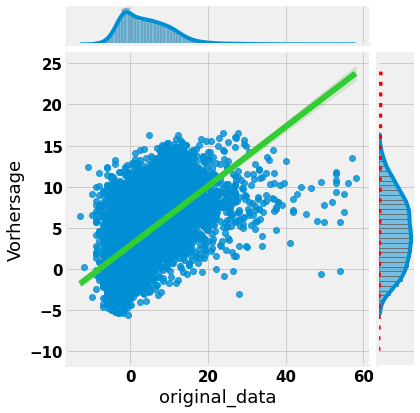

In [27]:
tips = pd.DataFrame()
tips["Vorhersage"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="Vorhersage", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mittlere Verspätungen (min)', fontsize = 15)
plt.ylabel('Vorhersage (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.show()

Polynomial Regression
I will now extend the previous fit by using a polynomial function instead of a linear one:

In [28]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X)
regr.fit(X_, Y)

LinearRegression()

In [29]:
result = regr.predict(X_)
print("MSE =", metrics.mean_squared_error(result, Y))

MSE = 30.160300953224688


It can be seen that polynomial fitting slightly improves the MSE value. In practice, the percentage of values where the difference between predictions and actual delays is greater than 15 minutes:

In [30]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-result[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(result) * 100)

'1.97%'

And as before, you can see that the model tends to be worse at large delays:

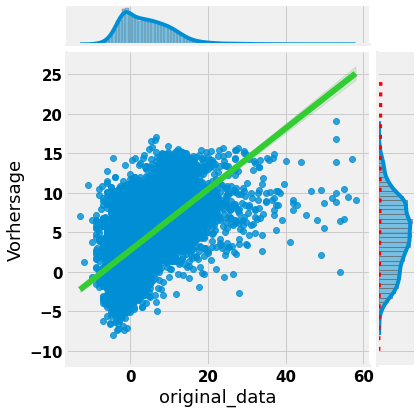

In [31]:
tips = pd.DataFrame()
tips["Vorhersage"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="Vorhersage", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mittlere Verspätungen (min)', fontsize = 15)
plt.ylabel('Vorhersage (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.show()

## Training


And as before, you can see that the model tends to be worse at large delays:


In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [33]:
X_train.shape

(7484, 87)

In [34]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
regr.fit(X_, Y_train)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_train)
print("Mean squared error = ", score)

Mean squared error =  30.6566128366923


In [35]:
somme = 0
for valeurs in zip(result, Y_test):
    ajout = (float(valeurs[0]) - float(valeurs[1]))**2
    somme += ajout
    if ajout > 10**4:
        print("{:<.1f} {:<.1f} {:<.1f}".format(ajout, float(valeurs[0]), float(valeurs[1])))

In [36]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.3,normalize=True)
poly = PolynomialFeatures(degree = 2)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)

Ridge(alpha=0.3, normalize=True)

In [37]:
X_ = poly.fit_transform(X_test)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Mean squared error =  29.821522873413983


In [38]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)        
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha, score))

n=1 alpha=0 , MSE = 30.102
n=1 alpha=2 , MSE = 30.303
n=1 alpha=4 , MSE = 31.05
n=1 alpha=6 , MSE = 31.941
n=1 alpha=8 , MSE = 32.835
n=1 alpha=10 , MSE = 33.68
n=1 alpha=12 , MSE = 34.457
n=1 alpha=14 , MSE = 35.165
n=1 alpha=16 , MSE = 35.808
n=1 alpha=18 , MSE = 36.392
n=2 alpha=0 , MSE = 30.915
n=2 alpha=2 , MSE = 30.277
n=2 alpha=4 , MSE = 30.535
n=2 alpha=6 , MSE = 30.858
n=2 alpha=8 , MSE = 31.225
n=2 alpha=10 , MSE = 31.618
n=2 alpha=12 , MSE = 32.02
n=2 alpha=14 , MSE = 32.423
n=2 alpha=16 , MSE = 32.819
n=2 alpha=18 , MSE = 33.207


In [39]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

31.361875492623643
